## Import 

In [2]:
!pip install fuzzywuzzy


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install pymed


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
from selenium import webdriver
from selenium_stealth import stealth
from selenium.webdriver.chrome.service import Service
from selectolax.lexbor import LexborHTMLParser
import os, json
from typing import List, Dict, Callable
import time, random, re
import pandas as pd
import requests
import io
from io import BytesIO
from io import StringIO
from bs4 import BeautifulSoup
import glob as glob
from fuzzywuzzy import fuzz
import numpy as np
from pymed import PubMed

/opt/anaconda3/envs/trimmer_lab/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Google Scholar Scraper

In [5]:
def SetResultDirectory():
    '''
    Returns desired directory for created dataframes from google scholar search 
    '''
    directory = '/Users/HMans_MacBook_Pro/Desktop/Test_Code/final_dfs'
    
    return directory 

In [6]:
def SetSummaryDataframe():
    '''
    Returns the location of where to put the summary table that shows how the google search went 
    by reporting number of articles found for each search term 
    
    This df should include the conversion catalog numbers from NeuroMab to Antibodies, and the seperate 
    results from each iteration
    '''
    directory = '/Users/HMans_MacBook_Pro/Desktop/Test_Code/runresults.xlsx'
    
    return directory

In [7]:
def SetYearParameters():
    '''
    Creates the years that are going to be used for the google scholar search 
    
    Returns : the first and last year you would like to search for 
    '''
    
    first_year = 2020
    last_year = 2023
    
    return first_year, last_year 

In [8]:
def RandomWait():
    '''
    This returns a random time between 5 and 10 sec for the 
    program to wait between requests in an attempt to limit being dropped from google 
    '''
    return random.randint(5, 10)

In [9]:
def CreatURLneuromabOnly():
    '''
    This function creates a url for the neuromab only search to compare the search 
    results to the found number of items 
    
    Returns : url to search 
    '''
    return f'https://scholar.google.com/scholar?q=%22Neuromab%22&hl=en&as_sdt=0%2C5&as_ylo={(SetYearParameters())[0]}&as_yhi={(SetYearParameters())[0]}'

In [10]:
def parse(parser: Callable, organic_results_data: Callable):
    '''
    Arugments:
    - parser:  Lexbor parser from scrape_google_scholar_organic_results() function.
    - organic_results_data: List to append data to. List origin location is scrape_google_scholar_organic_results() function. Line 104.
    
    This function parses data from Google Scholar Organic results and appends data to a List.
    
    It's used by scrape_google_scholar_organic_results().
    
    It returns nothing as it appends data to `organic_results_data`, 
    which appends it to `organic_results_data` List in the scrape_google_scholar_organic_results() function.
    '''
    
    for result in parser.css('.gs_r.gs_or.gs_scl'):
        try:
            title: str = result.css_first('.gs_rt').text()
        except: title = None

        try:
            title_link: str = result.css_first('.gs_rt a').attrs['href']
        except: title_link = None

        try:
            publication_info: str = result.css_first('.gs_a').text()
        except: publication_info = None

        try:
            snippet: str = result.css_first('.gs_rs').text()
        except: snippet = None

        try:
            # if Cited by is present in inline links, it will be extracted
            cited_by_link = ''.join([link.attrs['href'] for link in result.css('.gs_ri .gs_fl a') if 'Cited by' in link.text()])
        except: cited_by_link = None
        
        try:
            # if Cited by is present in inline links, it will be extracted and type cast it to integer
            cited_by_count = int(''.join([re.search(r'\d+', link.text()).group() for link in result.css('.gs_ri .gs_fl a') if 'Cited by' in link.text()]))
        except: cited_by_count = None
        
        try:
            pdf_file: str = result.css_first('.gs_or_ggsm a').attrs['href']
        except: pdf_file = None

        organic_results_data.append({
            'title': title,
            'title_link': title_link,
            'publication_info': publication_info,
            'snippet': snippet if snippet else None,
            'cited_by_link': f'https://scholar.google.com{cited_by_link}' if cited_by_link else None,
            'cited_by_count': cited_by_count if cited_by_count else None,
            'pdf_file': pdf_file
        })

def scrape_google_scholar_organic_results(
                                        query: str,
                                        pagination: bool = False,
                                        operating_system: str = 'Windows' or 'Linux',
                                        year_start: int = None,
                                        year_end: int = None,
                                        save_to_csv: bool = False, 
                                        save_to_json: bool = False
                                        ) -> List[Dict[str, str]]:
    '''
    Extracts data from Google Scholar Organic resutls page:
    - title: str
    - title_link: str
    - publication_info: str 
    - snippet: str
    - cited_by_link: str 
    - cited_by_count: int
    - pdf_file: str
    
    Arguments:
    - query: str. Search query. 
    - pagination: bool. Enables or disables pagination.
    - operating_system: str. 'Windows' or 'Linux', Checks for operating system to either run Windows or Linux verson of chromedriver
    
    Usage:
    data = scrape_google_scholar_organic_results(query='blizzard', pagination=False, operating_system='win') # pagination defaults to False 
    
    for organic_result in data:
        print(organic_result['title'])
        print(organic_result['pdf_file'])
    '''
    assert year_start and year_end
    if year_start or year_end:
        assert year_start and year_end
        assert year_start <= year_end

    # selenium stealth
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    
    options.add_experimental_option('excludeSwitches', ['enable-automation'])
    options.add_experimental_option('useAutomationExtension', False)
    
    # checks for operating system to either run Windows or Linux verson of chromedriver
    # expects to have chromedriver near the runnable file
    if operating_system is None:
        raise Exception('Please provide your OS to `operating_system` argument: "Windows" or "Linux" for script to operate.')
    
    if operating_system.lower() == 'windows' or 'win':
        driver = webdriver.Chrome(options=options, service=Service(executable_path='/home/chromedriver.exe'))
    
    if operating_system.lower() == 'linux': 
        driver = webdriver.Chrome(options=options, service=Service(executable_path='chromedriver'))
    
    stealth(driver,
        languages=['en-US', 'en'],
        vendor='Google Inc.',
        platform='Win32',
        webgl_vendor='Intel Inc.',
        renderer='Intel Iris OpenGL Engine',
        fix_hairline=True,
    )
    
    page_num: int = 0
    organic_results_data: list = []
    
    if pagination:
        while True:
            # parse all pages
            driver.get(f'https://scholar.google.com/scholar?q={query}&hl=en&gl=us&start={page_num}&as_ylo={year_start}&as_yhi={year_end}')
            parser = LexborHTMLParser(driver.page_source)
            parse(parser=parser, organic_results_data=organic_results_data)
            
            # pagination
            if parser.css_first('.gs_ico_nav_next'):  # checks for the "Next" page button
                page_num += 10                         # paginate to the next page
                time.sleep(random.randint(1, 7))      # sleep between paginations
            else:
                break
    else:
        # parse single, first page
        driver.get(f'https://scholar.google.com/scholar?q={query}&hl=en&gl=us&start={page_num}')
        parser = LexborHTMLParser(driver.page_source)
    
        parse(parser=parser, organic_results_data=organic_results_data)
        
    if save_to_csv:
        pd.DataFrame(data=organic_results_data).to_csv('google_scholar_organic_results_data.csv', 
                                                        index=False, encoding='utf-8')
    if save_to_json:
        pd.DataFrame(data=organic_results_data).to_json('google_scholar_organic_results_data.json', 
                                                        index=False, orient='records')
    driver.quit()
    return organic_results_data

In [24]:
!pip install webdriver-manager



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [41]:
!pwd


/Users/keithmitchell/Desktop/Repositories/NeuroMabSeq/trimmer/jupyter


In [42]:
scrape_google_scholar_organic_results(query='Neuromab', pagination=False, operating_system='linux', year_start=2020, year_end=2023, save_to_csv=True, save_to_json=True)

WebDriverException: Message: 'chromedriver.exe' executable needs to be in PATH. Please see https://chromedriver.chromium.org/home


In [11]:
def AddTargetCol(neuromab_website_df, final_df):
    '''
    Creates a list of the Target Item from the Neuromab dataframe website to append to final df
    
    Inputs : 
    df - neuromab df from web-site 
    final_df - dataframe that is having column added 
    
    Returns : 
    The new dataframe with the added column 
    '''     
    merged_df = final_df.merge(
        
        neuromab_website_df[['Clone', 'Target']], left_on=['Antibody'],right_on=['Clone'], how='left'
    
    )
    merged_df = merged_df.drop('Clone', axis=1)
   
    return merged_df

In [12]:
# Grab the neuromab website dataframe to be used to add the target columns 
data_Neuromab = requests.get("https://neuromab.ucdavis.edu/catalog-download.cfm").content
neuromab_website_df = pd.read_csv(BytesIO(data_Neuromab))

In [13]:
def CreateURL(query_name, TCSupe, PureID, NeuromabinQuery,MabIDinQuery,TCSupeInQuery,PureInQuery):
    '''
    Creates a URL to search Google Scholar for the results number at the top of the page 
    
    Inputs : 
    query_name = name of the antibody 
    TCSupe = the TC ID of AB
    PureID = Pure ID of AB
    NeuromabinQuery = Boolean value of whether or to put 'Neuromab' in the search 
    MabIDinQuery = Boolean value of whether or to put the Mab ID in the search
    TCSupeInQuery = Boolean value of whether or to put the TCSupe ID in the search
    PureInQuery = Boolean value of whether or to put the Pure ID in the search
    
    Returns : 
    a constructed URL to search 
    
    '''
    if NeuromabinQuery:
        First_name = 'Neuromab'
    else: 
        First_name = 'Antibodies+Inc'
        
    if MabIDinQuery:
        MABpt1, MABpt2 = query_name.split('/') 
        # EX URL : https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=“Neuromab+%22+%22N289%2F16%22&btnG=
        # EX query Search : “Neuromab ""N289/16" or "Antibodies Inc""N289/16"
        url = (
        f"https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&as_ylo={(SetYearParameters())[0]}&as_yhi={(SetYearParameters())[1]}&q='{First_name}'+%22%22{MABpt1}%2F{MABpt2}%22&btnG="
        )
    if TCSupeInQuery:
        # Ex URL : https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22Neuromab%22%2273-008%22&btnG=
        # Ex Query : "Neuromab""73-008" or "Antibodies Inc""73-008"
        url = (
        f"https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22'{First_name}'%22%22{TCSupe}%22&hl=en&as_sdt=0%2C5&as_ylo={(SetYearParameters())[0]}&as_yhi={(SetYearParameters())[1]}"
        )
    if PureInQuery:
        # Ex URL : https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22Neuromab%22%2275-008%22&btnG=
        # Ex Query : "Neuromab""75-008" or "Antibodies Inc""75-008"
        url = (
        f"https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22'{First_name}'%22%22{PureID}%22&hl=en&as_sdt=0%2C5&as_ylo={(SetYearParameters())[0]}&as_yhi={(SetYearParameters())[1]}"
        )
            
    return url

In [14]:
def CreateDF(query_name, result_value, data, GS_directory, filename, Iteration_num, runresultsdf, developer_mode):
    '''
    
    Creates a dataframe of the search results from Google scholar, prints different alert depending 
    on how many papers are different from search result number and results found from scraping GS
    
    Inputs : 
    query_name = the neuromab ID 
    result_value = the number of results found from a search, used to compare to google 
                    scholar scraper results 
    data = the tabel created from the google scholar search results 
    GS_directory = the location of the table from the google scholar search reesults 
    filename = the neuromab ID
    Iteration_num = the column that is being searched through, creates different results based on 
                    iteration number 
                    
    Returns : 
    a dataframe of the search results from a single search term 
    
    '''
    
    data_length = int({len(data)}.pop())

    # Record the difference between search result # and data length 
    count = (int(result_value)) - (int(data_length))
    final_df = pd.DataFrame(data)

    # Get rid of extraneous strings from title 
    final_df['title'] = final_df['title'].str.replace(
        '\[HTML\]\[HTML\]|\[PDF\]\[PDF\]|\[CITATION\]|\[C\]|\[BOOK\]\[BOOK\]|\[B\]|\[BOOK\]\[B\]', ''
    )

    filename = filename.replace('/','_')

    # Input Antibody name into table 
    final_df["Antibody"] = query_name 
    final_df = AddTargetCol(neuromab_website_df,final_df)
    final_df = final_df.rename(columns={'title': 'Title', 'cited_by_count': 'Cited by'})
    columns_to_drop = [1,2,3,4,6]  # Column numbers to drop
    final_df.drop(final_df.columns[columns_to_drop], axis=1, inplace=True)

    if developer_mode is True:
        print(f'Length of created dataframe is {data_length}')
        print(f'{filename} saved to {GS_directory}')
        # Input different result string based on difference in count 
        if count == 0:
            print(f'{query_name} All {data_length} accounted for: DF saved to file')
            runresultsdf.loc[runresultsdf['Clone'] == query_name, 'Iteration '+str(Iteration_num)] = f'All {data_length} accounted for'
        elif (count < (int(result_value) * .8)) and (count > 0):
            print(f'{query_name} : Out of {data_length} there seems to be {count} paper(s) w/o years')
            runresultsdf.loc[runresultsdf['Clone'] == query_name, 'Iteration '+str(Iteration_num)] = f'There seems to be {count} paper(s) w/o years, out of {data_length}'
        else:
            print(f'{query_name} Out of {data_length}, {count} paper(s) w/o years')
            runresultsdf.loc[runresultsdf['Clone'] == query_name, 'Iteration '+str(Iteration_num)] = f'Out of {data_length}, {count} paper(s) are w/o year(s)'
        
    final_df.to_csv(os.path.join(GS_directory, filename), index=False)
    return final_df

In [15]:
def Scholar_Query(leftoff, Iteration_num, developer_mode):
    '''
    Main Scraping function 
    
    Args : 
    
        - leftoff (int) takes the row number of the summary dataframe from where you would
        like to start your search 
        
        - Iteration_num (int) defines from what row to take information for query 
    
    Returns : 
    
        - dataframes for each successful GS search, containing information 
    on the paper that mentions a neuromab 
    
        - also updates the summary dataframe which shows results from searches 
        i.e. how many papers were found for each antibody, and where the search 
        left off 
        
    '''
    ## pass directory names to functions 

    # Initialize a value to count 0 result pages 
    zero_result_counter = 0

    # Initialize result directory path
    GS_directory = SetResultDirectory()

    # Initialize summary directory path and df
    SUM_df = SetSummaryDataframe()
    runresultsdf = pd.read_excel(SUM_df)
    
    # If we are only searching for NeuroMab, we wont iterate through the searches in the catalog dataframe 
    if Iteration_num == 7:
            query = ('"Neuromab"')
            url = CreatURLneuromabOnly()
            filename = f'Neuromab_only_{(SetYearParameters())[0]}_{(SetYearParameters())[1]}.csv'
            # filename = f'Neuromab_only_search.csv
            
            print(f"Starting search for NeuroMab only from {(SetYearParameters())[0]} to {(SetYearParameters())[1]}")
            # Grab data from google scholar 
            data = scrape_google_scholar_organic_results(query=query,
                                                         pagination=True,
                                                         operating_system="Windows",
                                                         year_start=(SetYearParameters())[0],
                                                         year_end=(SetYearParameters())[1]
                                                    )
            
            # create a dataframe of the search result 
            neuromab_only_df = pd.DataFrame(data)
            
            print(f'URL is {url}')
            url_info = requests.get(url)
            time.sleep(RandomWait())
            html = url_info.text

            # Create a BeautifulSoup object from the HTML string
            soup = BeautifulSoup(html, 'html.parser')
            result_elem = soup.select_one('#gs_ab_md .gs_ab_mdw')

            # Create text from Google Scholar Page and find search results number. 
            if result_elem:
                result_text = result_elem.get_text(strip=True)
                result_match = re.search(r'(\d+[\d,]*)\s+results', result_text)

                if result_match == None:
                    result_match = re.search(r'(\d+[\d,]*)\s+result', result_text)

                if result_match:
                    result_value = result_match.group(1)
                    result_value = result_value.replace(',', '')
                    print(f'Results search value is {result_value}')
                    
            data_length = int({len(data)}.pop())
            print(f'Length of created dataframe is {data_length}')

            # Record the difference between search result # and data length 
            count = (int(result_value)) - (int(data_length))
            print(f'The difference between number of items in dataframe and google search is {count}')
        
            # Get rid of extraneous strings from title 
            neuromab_only_df['title'] =  neuromab_only_df['title'].str.replace(
                '\[HTML\]\[HTML\]|\[PDF\]\[PDF\]|\[CITATION\]|\[C\]|\[BOOK\]\[BOOK\]|\[B\]|\[BOOK\]\[B\]', ''
            )

            # Save df 
            neuromab_only_df.to_csv(os.path.join(GS_directory, filename), index=False)
            print(f'{filename} saved to {GS_directory}')
            
            # merge the neuromab only search dataframes 
            merge_neuromab_only_dfs(GS_directory)
            
    # for all other search types we will iterate through the summary df for the information we need for 
    # the search terms 
    else:
        for index, row in runresultsdf.iloc[leftoff:].iterrows():
            data = {}
            query_name = row['Clone']
            TCSupe = row['AICatalogTCSupe']
            PureID = row['AICatalogPure']

            print(f"\nStarting Google Scholar scrape for {query_name}, Iteration {str(Iteration_num)}, Row {str(row[0])}...")


            # Set query for google scholar 
            # Example: “Neuromab " "N289/16"
            # and create URL to grab search results number
            # and set filename for query df 

            if Iteration_num == 1:
                query = (
                    '"Neuromab"' +  
                    f'"{query_name}"' 
                )
                url = CreateURL(query_name, 
                                 TCSupe, 
                                 PureID, 
                                 NeuromabinQuery=True, 
                                 MabIDinQuery=True,
                                 TCSupeInQuery=False,
                                 PureInQuery=False
                            )
                filename = f'Neuromab_{query_name}.csv'

            if Iteration_num == 2:
                query = (
                    '"Neuromab"' +  
                    f'"{TCSupe}"' 
                )
                url = CreateURL(query_name, 
                                 TCSupe, 
                                 PureID, 
                                 NeuromabinQuery=True, 
                                 MabIDinQuery=False,
                                 TCSupeInQuery=True,
                                 PureInQuery=False
                            )
                filename = f'Neuromab_{TCSupe}.csv'

            if Iteration_num == 3:
                query = (
                    '"Neuromab"' +  
                    f'"{PureID}"' 
                )
                url = CreateURL(query_name, 
                                 TCSupe, 
                                 PureID, 
                                 NeuromabinQuery=True, 
                                 MabIDinQuery=False,
                                 TCSupeInQuery=False,
                                 PureInQuery=True
                            )
                filename = f'Neuromab_{PureID}.csv'

            if Iteration_num == 4:
                query = (
                    '"Antibodies Inc"' +  
                    f'"{query_name}"' 
                )
                url =  CreateURL(query_name, 
                                 TCSupe, 
                                 PureID, 
                                 NeuromabinQuery=False, 
                                 MabIDinQuery=True,
                                 TCSupeInQuery=False,
                                 PureInQuery=False
                            )
                filename = f'AntibodiesInc_{query_name}.csv'

            if Iteration_num == 5:
                query = (
                    '"Antibodies Inc"' +  
                    f'"{TCSupe}"' 
                )
                url =  CreateURL(query_name, 
                                 TCSupe, 
                                 PureID, 
                                 NeuromabinQuery=False, 
                                 MabIDinQuery=False,
                                 TCSupeInQuery=True,
                                 PureInQuery=False
                            )
                filename = f'AntibodiesInc_{TCSupe}.csv'

            if Iteration_num == 6:
                query = (
                    '"Antibodies Inc"' +  
                    f'"{PureID}"' 
                )
                url =  CreateURL(query_name, 
                                 TCSupe, 
                                 PureID, 
                                 NeuromabinQuery=False, 
                                 MabIDinQuery=False,
                                 TCSupeInQuery=False,
                                 PureInQuery=True
                            )
                filename = f'AntibodiesInc_{PureID}.csv'

            print(f"Query is {query}")
            url_info = requests.get(url)
            time.sleep(RandomWait())
            html = url_info.text

            # Create a BeautifulSoup object from the HTML string
            soup = BeautifulSoup(html, 'html.parser')
            result_elem = soup.select_one('#gs_ab_md .gs_ab_mdw')

            # Create text from Google Scholar Page and find search results number. 
            if result_elem:
                result_text = result_elem.get_text(strip=True)
                result_match = re.search(r'(\d+[\d,]*)\s+results', result_text)

                if result_match == None:
                    result_match = re.search(r'(\d+[\d,]*)\s+result', result_text)

                if result_match:
                    result_value = result_match.group(1)
                    result_value = result_value.replace(',', '')
                    
                    if developer_mode is True:
                        print(f'URL is {url}')
                        print(f'Results search value is {result_value}')
                        
                    # Grab data from google scholar 
                    data = scrape_google_scholar_organic_results(query=query,
                                                                 pagination=True,
                                                                 operating_system="Windows",
                                                                 year_start=(SetYearParameters())[0],
                                                                 year_end=(SetYearParameters())[1]
                                                    )

                    final_df = CreateDF(query_name,
                                        result_value,
                                        data, 
                                        GS_directory,
                                        filename,
                                        Iteration_num,
                                        runresultsdf,
                                        developer_mode
                                    )

                else:
                    if developer_mode is True:
                        print(f'{query} No research Published')
                        
                    runresultsdf.loc[runresultsdf['Clone'] == query_name, 'Iteration '+str(Iteration_num)] = "No research Published"


            else:
                print(f'{query} No result element, we got dropped')
                runresultsdf.loc[runresultsdf['Clone'] == query_name, 'Iteration '+str(Iteration_num)] = 'No result element, we got dropped'
                zero_result_counter += 1
                if zero_result_counter >= 1:
                    print(f'Ending Scraper on {query_name} row {str(row[0])}')
                    # Iterate through the columns and delete any that start with "Unnnamed"
                    for col in runresultsdf.columns:
                        if col.startswith("Unnamed"):
                            runresultsdf = runresultsdf.drop(col, axis=1)
                    runresultsdf.to_excel(SUM_df)
                    print(f'Summary Result Table saved to {SUM_df}')
                    break

In [16]:
def merge_neuromab_only_dfs(GS_directory):
    '''
    Merges the Neuromab search only dfs. Since the Neuromab only searches create more search results than allowed, 
    these dataframes from seperate year ranges will need to be merged together
    
    Returns : a merged dataframe of all neuromab onnly search results 
    '''
    # create a list of dataframes
    dfs = []
    for filename in glob.glob(f'{GS_directory}/Neuromab_only_*.csv'):
        df = pd.read_csv(filename)
        dfs.append(df)

    # concatenate the dataframes vertically and rename columns
    merged = pd.concat(dfs, ignore_index=True)[['title', 'cited_by_count']] \
             .rename(columns={'title': 'Title', 'cited_by_count': 'Cited by'})

    merged.to_csv(f'{GS_directory}/Merged_Neuromab_Only_Search.csv')

In [ ]:
Scholar_Query()

In [17]:
Scholar_Query(13, 2, False)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/HMans_MacBook_Pro/Desktop/Test_Code/runresults.xlsx'

## Merging


In [77]:
def create_filename_of_merged_dfs():
    filename_of_merged_df = location_of_results + '/all_publications_merged_df.csv'
    return filename_of_merged_df

In [78]:
def merge_created_dataframes_from_GS():
    '''
    Description :
    
    this function merges the created dataframes from the searches in to a single dataframe 
    
    Returns : 
    
    a merged dataframe 
    
    Constraints :
    
    make sure that any merged dataframes with the exception of the Neuromab only 
    search dataframes that were merged prior are the only files in the directory. Otherwise 
    some of the functions in this code will not work 
    '''

    # Collection of all of the created dataframes in results directory into a list 
    df_list = []
    location_of_results = SetResultDirectory()
    filename_of_merged_df = create_filename_of_merged_dfs()

    for file in os.listdir(location_of_results):
        if '.csv' in file:
            df = pd.read_csv(f"{location_of_results}/{file}")
            df_list.append(df)

    publications_neuromab_df = pd.concat(df_list)

    # Group by 'title' column and aggregate 'antibody' column 
    def concatenate_antibodies(antibodies):
        # Convert non-string values to empty strings
        antibodies = [str(ab) for ab in antibodies if isinstance(ab, (str, int))]
        return ', '.join(set(antibodies))  # Join unique antibodies with commas

    def concatenate_targets(targets):
        # Convert non-string values to empty strings
        targets = [str(t) for t in targets if isinstance(t, (str, int))]
        return ', '.join(set(targets))  # Join unique targets with commas

    # group the antbodies and targets togtheer in the same column of the same paper row 
    publications_neuromab_df['Antibody'] = publications_neuromab_df.groupby('Title')['Antibody'].transform(concatenate_antibodies)
    publications_neuromab_df['Target'] = publications_neuromab_df.groupby('Title')['Target'].transform(concatenate_targets)

    # Remove white spaces in the DataFrame, except for spaces between words
    publications_neuromab_df = publications_neuromab_df.replace(r'\s+', ' ', regex=True).applymap(lambda x: x.strip() if isinstance(x, str) else x)

    # Drop duplicate rows based on 'title' column
    publications_neuromab_df.drop_duplicates(subset='Title', keep='first', inplace=True)

    # Reset the index
    publications_neuromab_df.reset_index(drop=True, inplace=True)

    # Rename columns Antibody and Target 
    publications_neuromab_df = publications_neuromab_df.rename(columns={'Antibody':'Neuromab(s)','Target':'Target(s)'})

    # Iterate over 'Target(s)' column and reverse the order of items
    for index, row in publications_neuromab_df.iterrows():
        targets = row['Target(s)'].split(', ')  # Split items by comma and space
        reversed_targets = ', '.join(reversed(targets))  # Reverse the order of items
        publications_neuromab_df.at[index, 'Target(s)'] = reversed_targets  # Update 'Target(s)' column

    # Drop columns that start with 'Unnamed'
    publications_neuromab_df = publications_neuromab_df.loc[:, ~publications_neuromab_df.columns.str.startswith('Unnamed')]

    # Save dataframe to csv 
    publications_neuromab_df.to_csv(filename_of_merged_df)

In [79]:
# Main call to merging function 
merge_created_dataframes_from_GS()

In [58]:
def generate_path_to_merged_df():
    path_to_merged_df = '/Users/HMans_MacBook_Pro/Desktop/Test_Code/final_dfs/all_publications_merged_df.csv'
    return path_to_merged_df

In [74]:
def add_Pubmed_info_to_dataframe(leftoff, autosave, df, developer_mode):
    '''
    Description : 
    
    This function uses the PubMed tool to generate the pubmed ID from the value in the Title 
    column of each row of the desired dataframe
    
    Input : 
    
    leftoff = from what row you would like to start adding information to 
    
    autosave = the number of iterations before being saved as csv
    
    df = the desired dataframe to add the information to 
    
    Returns : 
    
    a dataframe with the PMID, Author, Publication Date, and Journal columns appended
    
    '''

    # initialize the tool being used 
    pubmed = PubMed(tool="PubMedSearcher", email="gmail.com")

    # read in desired dataframe 
    df = pd.read_csv(generate_path_to_merged_df())
    
    # Initialize columns values to be added to NaN
    if 'PMID' not in df:
        df['PMID'] = np.nan
    if 'Author' not in df:
        df['Author'] = np.nan
    if 'Publication Date' not in df:
        df['Publication Date'] = np.nan
    if 'Journal' not in df:
        df['Journal'] = np.nan

    # iterate over the df from the desginated row 
    for index, row in df[leftoff:].iterrows():
        if pd.isna(row['title']):    # if the value in Title is empty skip over it 
            continue

        if not pd.isna(row['PMID']): # if there is a value in the PMID column skip over it 
            continue

        search_term = row['title']
        max_results = 500
        results = pubmed.query(search_term, max_results=max_results)
        last_pubmedId = None  # Initialize to None

        # iterate through each of the paper titles in results, if the title is 80% similar to one of the 
        # articles - then that is the paper that we will grab information from 
        for article in results:
            title = article.title
            pubmedId = article.pubmed_id.partition('\n')[0]

            # Compare the similarity of the title and the search term
            similarity = fuzz.token_set_ratio(title.lower(), search_term.lower())
            if similarity >= 80:
                last_pubmedId = pubmedId
                break

        if last_pubmedId is not None:  # Only assign pubmed_id if a significant title is found
            if developer_mode is True:
                print(row['Title'],last_pubmedId)
            df.at[index, 'PMID'] = last_pubmedId   # assign the PMID to the row 
            df.at[index, 'Date'] = article.publication_date # assign the publication date to the row 

            # Create the Publication information from the first authors name and 
            # journal the paper is from 
            authors = article.authors
            # Extracting the first author's lastname
            first_author_lastname = authors[0]['lastname']

            # Creating the "et al" part
            et_al = "et al"

            # Creating the formatted string for publication info
            publication_info = f"{first_author_lastname} {et_al}. {article.journal}"
            df.at[index, 'Publication'] = publication_info

        # save the dataframe whenever there are 100 iterations - there is a possibility of being dropped
        if index % autosave == 0:
            df.to_csv(generate_path_to_merged_df())
    
    # remove the 'unnamed' column from the df 
    for col in runresultsdf.columns:
        if col.startswith("Unnamed"):
            runresultsdf = runresultsdf.drop(col, axis=1)
            
    # Delete duplicates in the PMID column 
    df = df.drop_duplicates(subset='PMID', keep='first')
    
    return df


In [76]:
NeuroMabdf = add_Pubmed_info_to_dataframe(1, 50, pd.read_csv(generate_path_to_merged_df()), False)


KeyboardInterrupt



# !CAUTION!
## Be sure the newly created dataframe is correct
### after double-checking that the dataframe it to your liking (PMIDs have been found correctly, and ones that had to be found manually are inputted) this code will delete the rows in the dataframe that have a NaN value in the PMID column and as a result could make some unwanted deletions if not checked

In [436]:
# delete duplicates and remove those that are NA 

# read the CSV file into a pandas dataframe
NeuroMabdf = pd.read_csv(generate_path_to_merged_df())


# iterate over the 'PMID' column and remove rows that don't have a value
for idx, val in NeuroMabdf['PMID'].iteritems():
    if pd.isnull(val):
        NeuroMabdf = NeuroMabdf.drop(idx)

NeuroMabdf.to_csv(generate_path_to_merged_df())
#print(NeuroMabdf)

/var/folders/5l/c6klb_vn5csf5rgx737xbgg80000gp/T/ipykernel_28889/1383991239.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, val in df['PMID'].iteritems():


In [ ]:
def generate_path_to_master_df():
    path_to_master = ''
    return path_to_master

In [97]:
def merge_with_master():
    '''
    This function takes the newly created dataframes and merges them with the master dataframe 
    '''
    master_df_GS = generate_path_to_master_df()
    
    

## Analysis of Created Dataframe 

In [580]:
# Average number of Antibodies per publication 

# Sample dataframe
neuromab_df = pd.read_csv(generate_path_to_merged_df())

def count_items(row):
    neuromabs = row['Neuromab(s)']
    if isinstance(neuromabs, str):
        return len(neuromabs.split(','))
    else:
        return 0


# Apply the function to each row and store the counts in a new column
neuromab_df['Number of AB\'s'] = neuromab_df.apply(count_items, axis=1)

# Display the updated dataframe
#print(neuromab_df)

# Calculate the average of the values in the 'Number of AB\'s' column
average = neuromab_df['Number of AB\'s'].mean()

# Display the average
print("Average number of AB's used in each publication: ", average)


Average number of AB's used in each publication:  1.0667451904201022


In [581]:
# Number of Publications without PubMed ID 
import pandas as pd

# Count the number of empty values in the 'Publication' column
count = 0
count_2 = 0 

for pub in neuromab_df['Publication']:
    if pd.isna(pub) or pub == '':
        count += 1
        
for pub in neuromab_df['Neuromab(s)']:
    if pd.isna(pub) or pub == '':
        count_2 += 1

# Get the total number of rows in the DataFrame
rows = len(neuromab_df)

# Print the count of publications without a PubMed ID and the total number of rows
print(f'The total number of publication results is {rows}')
print(f'The number of publications with a PubMed ID is {rows - count} - ({count} without PMID)')
print(f'The number of publications without referencing a specific NeuroMab is {count_2}')


The total number of publication results is 5094
The number of publications with a PubMed ID is 5069 - (25 without PMID)
The number of publications without referencing a specific NeuroMab is 1549


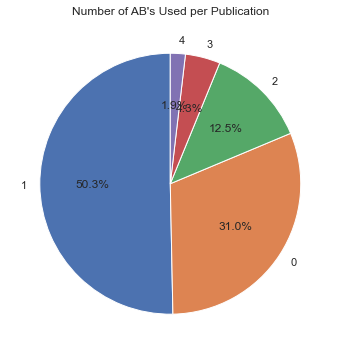

In [582]:
# Set a threshold for percentage display
threshold = 1.5 # Only display percentages above 1.5%

# Create a pie chart of the different numbers of antibodies used
# Count the occurrences of each unique value in 'Number of AB\'s' column
count_by_number = neuromab_df['Number of AB\'s'].value_counts()

# Calculate percentage for each count
percentages = count_by_number / count_by_number.sum() * 100

# Filter percentages based on threshold
filtered_percentages = percentages[percentages > threshold]

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(filtered_percentages, labels=filtered_percentages.index, autopct='%1.1f%%', startangle=90)
plt.title('Number of AB\'s Used per Publication')
plt.show()

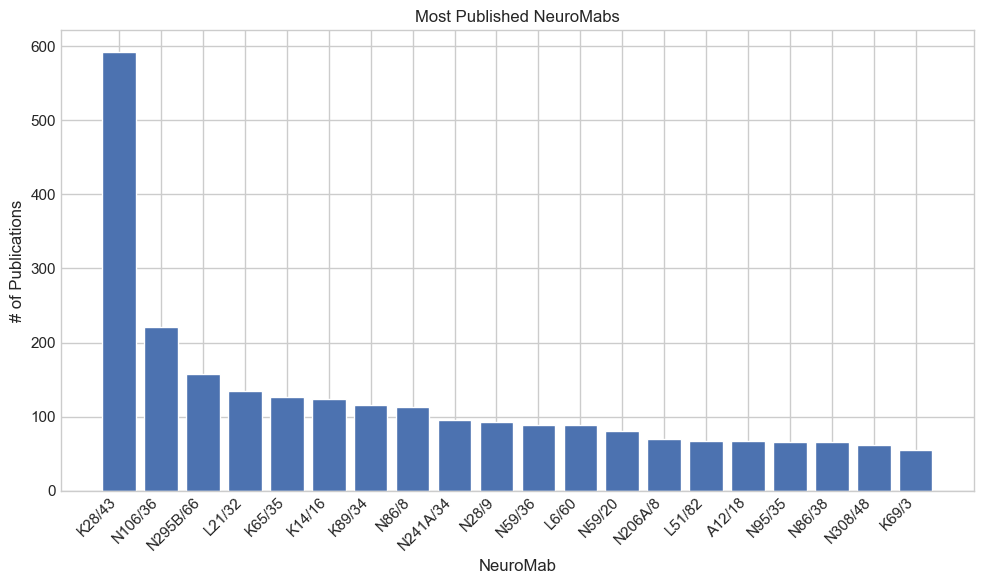

In [596]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the 'Neuromab(s)' column as a Series
neuromabs = neuromab_df['Neuromab(s)']

# Create a dictionary to store the counts of each item
item_counts = {}

# Iterate through the 'Neuromab(s)' column in the DataFrame
for row in neuromabs:
    # Check if the value is a float
    if isinstance(row, float):
        continue
        
    # Convert the value to a string and split the items by commas
    items = str(row).split(',')
    
    # Iterate through the items and update the counts
    for item in items:
        # Remove whitespace from each item
        item = item.strip()
        if item in item_counts:
            item_counts[item] += 1
        else:
            item_counts[item] = 1

# Sort the items by count in descending order
sorted_items = sorted(item_counts.items(), key=lambda x: x[1], reverse=True)
items = [item[0] for item in sorted_items]
counts = [item[1] for item in sorted_items]

# Filter items with count above 50
items_filtered = [item for item, count in zip(items, counts) if count > 50]
counts_filtered = [count for count in counts if count > 50]

# Create a figure with a larger size and higher resolution
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)


# Create a bar plot for filtered items
plt.bar(items_filtered, counts_filtered)
plt.xlabel('NeuroMab')
plt.ylabel('# of Publications')
plt.title('Most Published NeuroMabs')
# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


# publications per unit time (per month) since first appearance

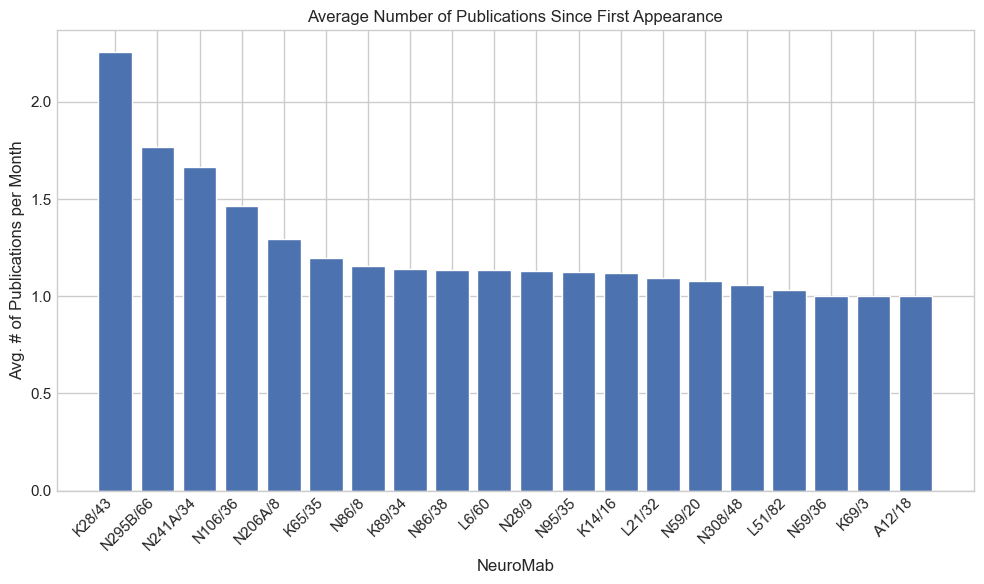

In [587]:
import pandas as pd
import matplotlib.pyplot as plt

# Parse the dates in the 'Date' column as datetime objects
neuromab_df['Date'] = pd.to_datetime(neuromab_df['Date'], format='%m/%d/%y')

# Create a new column 'Month' that contains only the month and year information
neuromab_df['Month'] = neuromab_df['Date'].dt.strftime('%Y-%m')

# Group the DataFrame by 'Neuromab(s)' and count the number of rows for each group
neuromab_counts = neuromab_df.groupby(['Neuromab(s)', 'Month']).size().reset_index(name='Publication Count')

# Filter the counts to keep only the unique Neuromab(s) published more than 50 times
neuromab_counts_filtered = neuromab_counts[neuromab_counts['Neuromab(s)'].isin(items_filtered)]

# Group the filtered counts by 'Neuromab(s)' and calculate the average publication count per month for each Neuromab(s)
neuromab_monthly_average = neuromab_counts_filtered.groupby('Neuromab(s)')['Publication Count'].mean()

# Sort the neuromab_monthly_average Series in descending order of values
neuromab_monthly_average = neuromab_monthly_average.sort_values(ascending=False)

# Set the style of the plot
plt.style.use('seaborn-whitegrid')

# Create a figure with a larger size and higher resolution
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Create a bar plot for the average publication count per month for each Neuromab(s)
ax.bar(neuromab_monthly_average.index, neuromab_monthly_average.values)

# Set the x-axis and y-axis labels and title of the plot
ax.set_xlabel('NeuroMab')
ax.set_ylabel('Avg. # of Publications per Month')
ax.set_title('Average Number of Publications Since First Appearance')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')

# Tighten the layout of the plot
fig.tight_layout()

# Display the plot
plt.show()


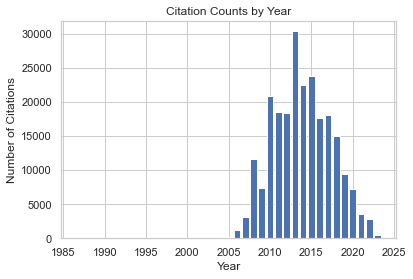

In [534]:
# Citations by year / Impact over time 

import pandas as pd
import matplotlib.pyplot as plt

# Extract the year from the Date column
neuromab_df['Year'] = pd.DatetimeIndex(neuromab_df['Date']).year

# Group the DataFrame by year and sum the Cited by column
citation_counts = neuromab_df.groupby('Year')['Cite Count'].sum()



# Create a bar graph of the citation counts by year
plt.bar(citation_counts.index, citation_counts.values)
plt.xlabel('Year')
plt.ylabel('Number of Citations')
plt.title('Citation Counts by Year')
plt.show()

# July 1st 2022 - March 31st 2023 


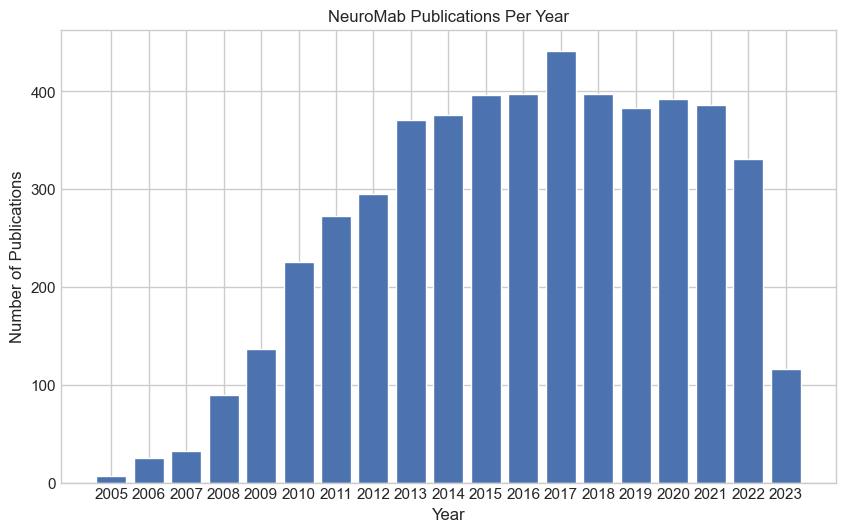

In [593]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the year from the Date column
neuromab_df['Year'] = pd.DatetimeIndex(neuromab_df['Date']).year

# Group the DataFrame by year and count the Publication column
pub_counts = neuromab_df.groupby('Year')['Publication'].count()

# Set the style of the plot
plt.style.use('seaborn-whitegrid')

# Create a figure with a larger size and higher resolution
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Create a bar graph of the publication counts by year
plt.bar(pub_counts.index, pub_counts.values)
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.title('NeuroMab Publications Per Year')

# Set x-ticks to only include whole years
plt.xticks(range(int(pub_counts.index.min()), int(pub_counts.index.max())+1))

plt.show()


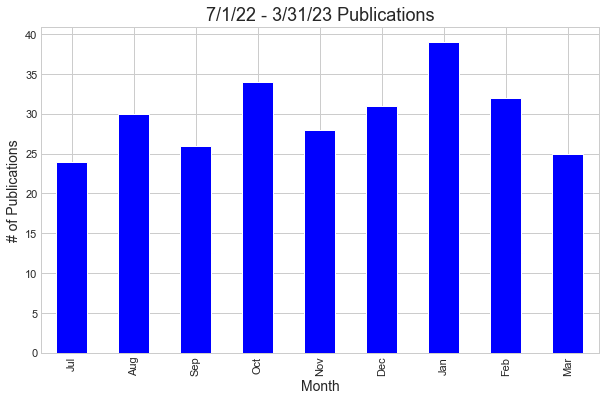

In [590]:
import pandas as pd
import matplotlib.pyplot as plt


# Convert the Date column to datetime format
neuromab_df['Date'] = pd.to_datetime(neuromab_df['Date'])

# Set the start and end dates
start_date = pd.to_datetime('2022-07-01')
end_date = pd.to_datetime('2023-03-31')

# Filter the DataFrame by date range
filtered_df = neuromab_df[(neuromab_df['Date'] >= start_date) & (neuromab_df['Date'] <= end_date)]

# Group the filtered DataFrame by month and count the number of papers
paper_counts = filtered_df.groupby(pd.Grouper(key='Date', freq='M')).size()

# Create a bar chart of the paper counts by month
ax = paper_counts.plot(kind='bar', color='blue', figsize=(10,6))

# Set the title and axis labels
ax.set_title('7/1/22 - 3/31/23 Publications', fontsize=18)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('# of Publications', fontsize=14)

# Format the x-axis labels as shortened month names
ax.set_xticklabels(paper_counts.index.strftime('%b'))

# Display the plot
plt.show()


In [591]:
# Calculate the total number of papers
total_papers = paper_counts.sum()
print(f'Number of Publications between 7/1/22 and 3/31/23 : {total_papers}')

Number of Publications between 7/1/22 and 3/31/23 : 269


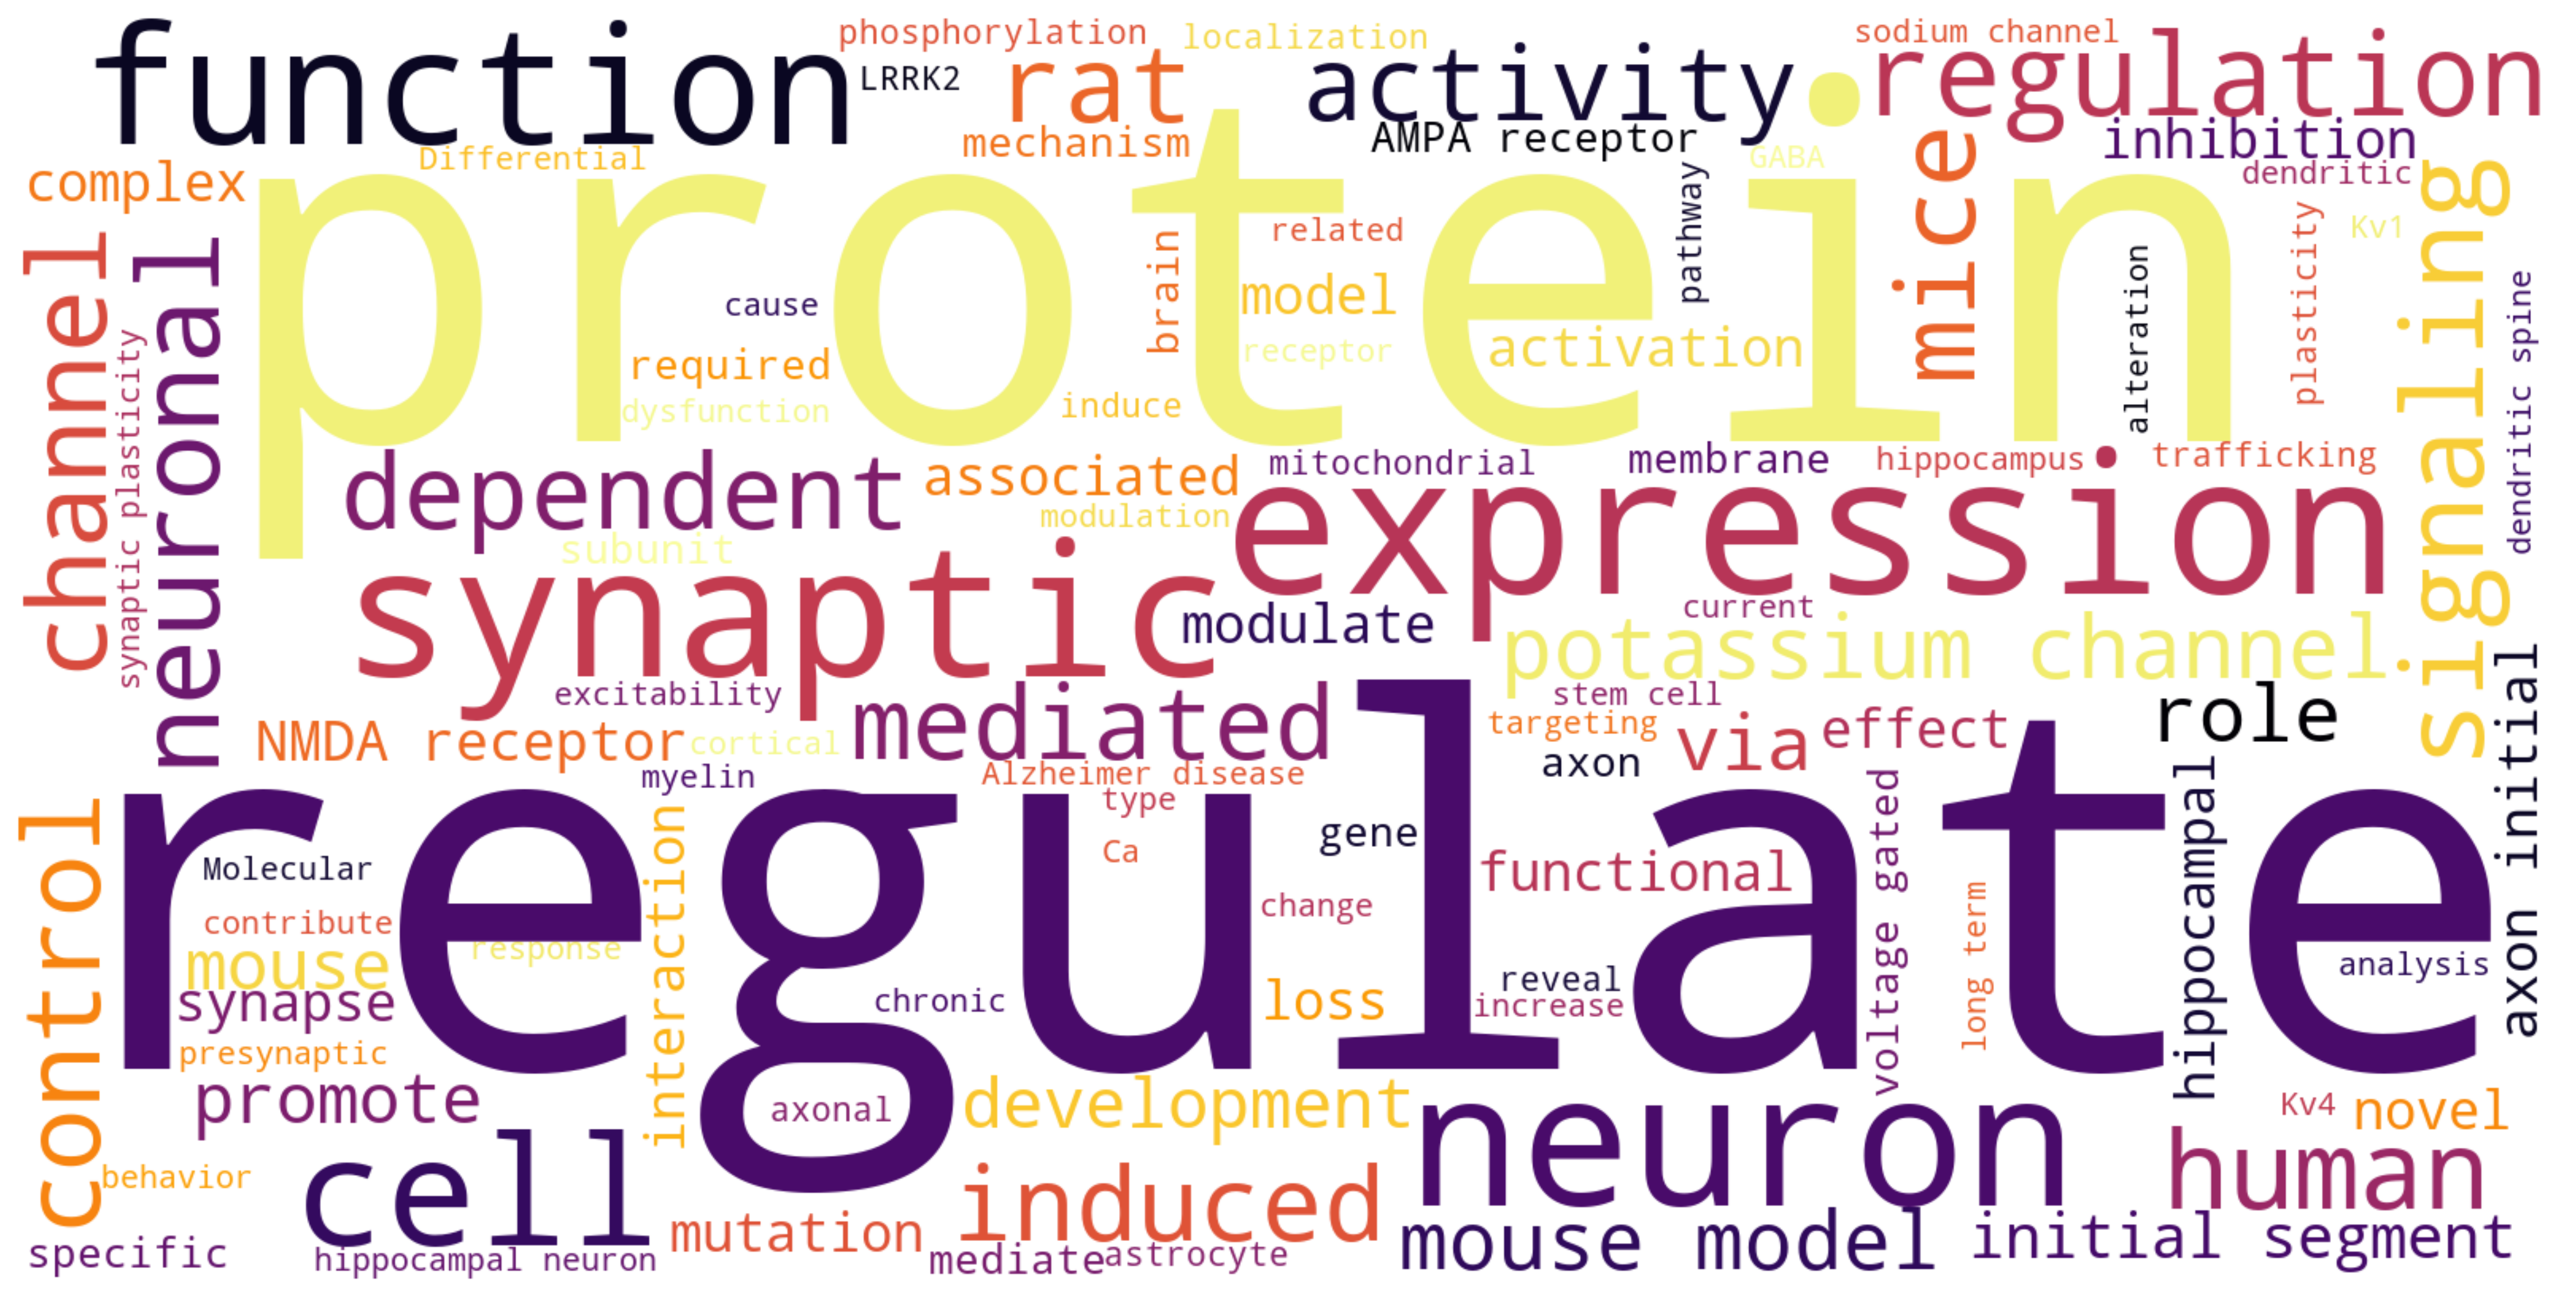

In [567]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert Title column to string data type and drop NaN values
titles = neuromab_df['Title'].astype(str).dropna()

# Join all titles into a single string
titles_text = " ".join(title for title in titles)

# Create a WordCloud object with some basic parameters
wordcloud = WordCloud(width=1600, height=800, background_color='white', colormap='inferno', max_words=100)

# Generate the word cloud
wordcloud.generate(titles_text)

# Plot the word cloud
plt.figure(figsize=(20, 10), dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud.png', bbox_inches='tight')
plt.show()
